In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# Creating Training and Validation Augmented Dataset

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=30,
                                     shear_range=0.2,
                                     brightness_range=((0.2, 0.8))
                                     )
  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(160, 160))
  validation_datagen = ImageDataGenerator(rescale=1/255,
                                          rotation_range=30,
                                          shear_range=0.2,)
  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(160, 160))
  
  return train_generator, validation_generator

In [ ]:
TRAINING_DIR = "/content/gdrive/My Drive/Project/Dataseto/training/"
TESTING_DIR = "/content/gdrive/My Drive/Project/Dataseto/validation/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 2419 images belonging to 2 classes.
Found 808 images belonging to 2 classes.


In [ ]:
denseModel = tf.keras.applications.densenet.DenseNet201(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

74850304/74836368 [==============================] - 2s 0us/step


In [ ]:
# Getting the last layer of DenseNet201 model
last_output = denseModel.output

fine_tune_at = 600

for layer in denseModel.layers[:fine_tune_at]:
  layer.trainable = False

# denseModel.trainable = False

# Global Average Pooling 2D initialization
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Adding New Layer
x = global_average_layer(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)

# Create model with DenseNet201 Model added with 3 new layers
model = tf.keras.Model(denseModel.input, x)

In [ ]:
bekup = model

In [ ]:
# Creating Callback Function to Stop Training when Accuracy Reached 95%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\naccuracy is higher than 95% so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Creating Callback Function to Save Model in Gdrive every 4 epochs
class Save(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      root_path = '/content/gdrive/My Drive/Project/models2/'
      if epoch%4 == 0:  
        path = os.path.join(root_path, str(epoch))
        os.makedirs(path,exist_ok=True)
        self.model.save("/content/gdrive/MyDrive/Project/models2/{}".format(epoch))
saver = Save()

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1/conv[0][0]']         

# Training Using DenseNet201 Model with Fine Tuning

In [ ]:
history_transfer = model.fit(train_generator,
                         epochs=41,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[saver])

Epoch 1/41
76/76 [==============================] - 701s 9s/step - loss: 0.4906 - accuracy: 0.7730 - val_loss: 0.4383 - val_accuracy: 0.8453
Epoch 2/41
76/76 [==============================] - 39s 519ms/step - loss: 0.3105 - accuracy: 0.8706 - val_loss: 0.3635 - val_accuracy: 0.8973
Epoch 3/41
76/76 [==============================] - 40s 524ms/step - loss: 0.2640 - accuracy: 0.8809 - val_loss: 0.3487 - val_accuracy: 0.8874
Epoch 4/41
76/76 [==============================] - 39s 510ms/step - loss: 0.2390 - accuracy: 0.8983 - val_loss: 0.3252 - val_accuracy: 0.8899
Epoch 5/41
76/76 [==============================] - 95s 1s/step - loss: 0.1954 - accuracy: 0.9173 - val_loss: 0.4112 - val_accuracy: 0.8540
Epoch 6/41
76/76 [==============================] - 39s 513ms/step - loss: 0.1605 - accuracy: 0.9330 - val_loss: 0.3450 - val_accuracy: 0.8824
Epoch 7/41
76/76 [==============================] - 39s 510ms/step - loss: 0.1533 - accuracy: 0.9405 - val_loss: 0.2837 - val_accuracy: 0.9084
Epoc

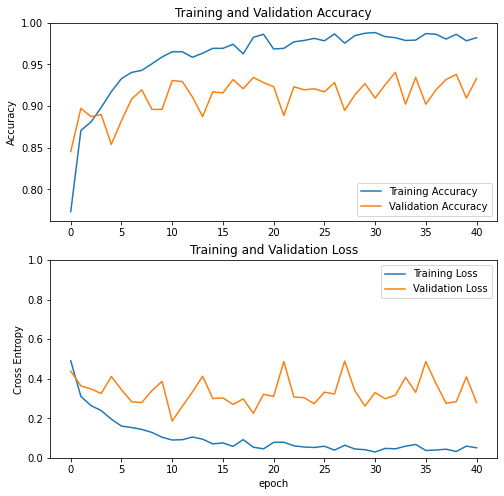

In [ ]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Transfer Learning DenseNet201 With Image Size of 480x480 Without Fine Tuning

In [ ]:
history_transfer = model.fit(train_generator,
                         epochs=40,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[saver])

Epoch 1/40
76/76 [==============================] - 963s 12s/step - loss: 0.7037 - accuracy: 0.4973 - val_loss: 0.6722 - val_accuracy: 0.4950
Epoch 2/40
76/76 [==============================] - 178s 2s/step - loss: 0.6776 - accuracy: 0.5271 - val_loss: 0.6516 - val_accuracy: 0.5532
Epoch 3/40
76/76 [==============================] - 180s 2s/step - loss: 0.6580 - accuracy: 0.5601 - val_loss: 0.6352 - val_accuracy: 0.5507
Epoch 4/40
76/76 [==============================] - 177s 2s/step - loss: 0.6465 - accuracy: 0.5717 - val_loss: 0.6244 - val_accuracy: 0.6027
Epoch 5/40
76/76 [==============================] - 232s 3s/step - loss: 0.6211 - accuracy: 0.6110 - val_loss: 0.6047 - val_accuracy: 0.6300
Epoch 6/40
76/76 [==============================] - 182s 2s/step - loss: 0.6090 - accuracy: 0.6292 - val_loss: 0.5912 - val_accuracy: 0.6300
Epoch 7/40
76/76 [==============================] - 179s 2s/step - loss: 0.5991 - accuracy: 0.6358 - val_loss: 0.5860 - val_accuracy: 0.6683
Epoch 8/40
7

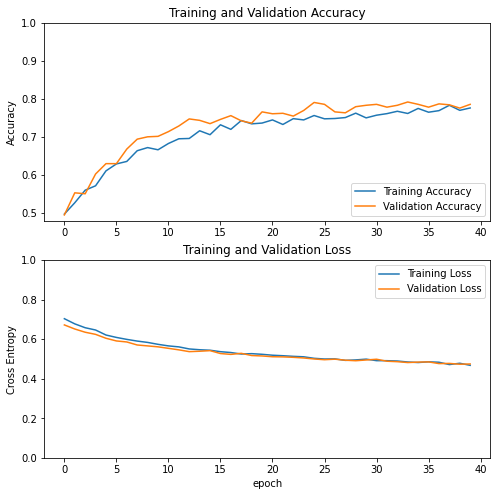

In [ ]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Transfer Learning DenseNet201 with Callback To End Training at 95% Accuracy

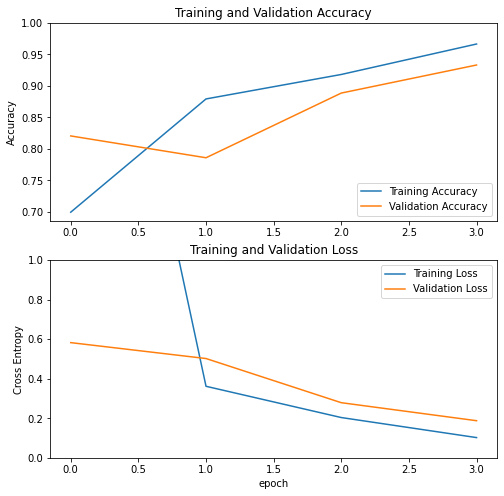

In [ ]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Project/genius')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project/genius/assets


# Test Model

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)
  print(fn)
  print(classes)

Saving 56364796.png to 56364796.png
56364796.png
[[-29.646866]]


# Tried to Continue Learning of Model With Callback 95% Accuracy

In [ ]:
dingdong = tf.keras.models.load_model('/content/gdrive/MyDrive/Project/genius')

In [ ]:
backup = dingdong

In [ ]:
history_transfer = dingdong.fit(train_generator,
                         epochs=7,
                         verbose=1,
                         validation_data=validation_generator)

Epoch 1/7
38/38 [==============================] - 651s 17s/step - loss: 0.3876 - accuracy: 0.8636 - val_loss: 0.2014 - val_accuracy: 0.9220
Epoch 2/7
38/38 [==============================] - 194s 5s/step - loss: 0.1033 - accuracy: 0.9661 - val_loss: 0.1745 - val_accuracy: 0.9493
Epoch 3/7
38/38 [==============================] - 195s 5s/step - loss: 0.0731 - accuracy: 0.9756 - val_loss: 0.2055 - val_accuracy: 0.9282
Epoch 4/7
38/38 [==============================] - 190s 5s/step - loss: 0.0477 - accuracy: 0.9822 - val_loss: 0.1666 - val_accuracy: 0.9443
Epoch 5/7
38/38 [==============================] - 188s 5s/step - loss: 0.0352 - accuracy: 0.9880 - val_loss: 0.1736 - val_accuracy: 0.9381
Epoch 6/7
38/38 [==============================] - 188s 5s/step - loss: 0.0275 - accuracy: 0.9942 - val_loss: 0.1671 - val_accuracy: 0.9517
Epoch 7/7
38/38 [==============================] - 188s 5s/step - loss: 0.0265 - accuracy: 0.9905 - val_loss: 0.1581 - val_accuracy: 0.9480


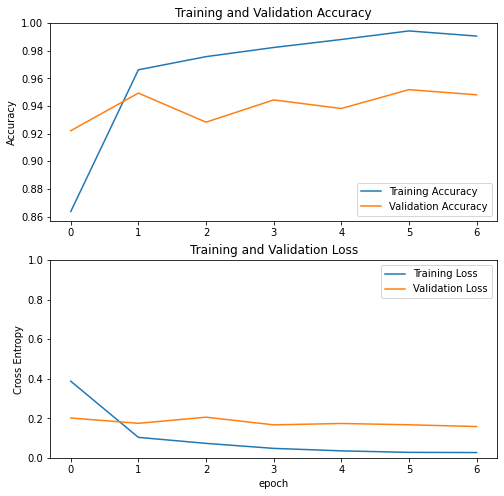

In [ ]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(480, 480))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = dingdong.predict(images)
  print(fn)
  print(classes)

Saving Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png to Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png
Saving Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%0.png to Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%0.png
Saving Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%1.png to Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%1.png
Saving Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%2.png to Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%2.png
Saving Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%3.png to Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%3.png
Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_Internationa

# Convert to TFjs

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 40 kB 7.1 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
model_load = tf.keras.models.load_model('/content/gdrive/MyDrive/Project/models2/40')

In [ ]:
import tensorflowjs as tfjs

tfjs_target_dir = "/content/gdrive/MyDrive/Project/TFjs_Model/"

tfjs.converters.save_keras_model(model_load, tfjs_target_dir)

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255

  images = np.vstack([x])
  classes = model_load.predict(images)

  if classes < 0:
    classes = 'covid'
    print(classes)
  else:
    classes = 'non-covid'
    print(classes)
  print(fn)
  

Saving Covid (10).png to Covid (10).png
Saving Non-Covid (3).png to Non-Covid (3).png
covid
Covid (10).png
non-covid
Non-Covid (3).png
